# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [68]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

In [28]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [29]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [30]:
query_main="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 12
"""
df_main = pd.read_sql_query(query_main, conn)


C:\Users\Zóra\AppData\Local\Temp\ipykernel_37828\2361332938.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_main = pd.read_sql_query(query_main, conn)


In [31]:
pd.set_option('display.max_columns', None)

df_main

,ts,net_load
0,2019-03-01 15:15:00,1011.03
1,2019-03-01 15:30:00,797.85
2,2019-03-01 15:45:00,512.28
3,2019-03-01 16:00:00,241.41
4,2019-03-01 16:15:00,137.48
...,...,...
38031,2020-03-31 22:45:00,8.49
38032,2020-03-31 23:00:00,8.70
38033,2020-03-31 23:15:00,8.67
38034,2020-03-31 23:30:00,8.52


In [32]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38036 entries, 0 to 38035
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38036 non-null  datetime64[ns]
 1   net_load  38036 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 594.4 KB


## Convert Convert 'ts' to datetime and set as index

In [33]:
df_main['ts'] = pd.to_datetime(df_main['ts'])
df_main.set_index('ts', inplace=True)

In [34]:
df_main

,net_load
ts,
2019-03-01 15:15:00,1011.03
2019-03-01 15:30:00,797.85
2019-03-01 15:45:00,512.28
2019-03-01 16:00:00,241.41
2019-03-01 16:15:00,137.48
...,...
2020-03-31 22:45:00,8.49
2020-03-31 23:00:00,8.70
2020-03-31 23:15:00,8.67


In [35]:
# N.o. lags can be tuned according to model performance
number_of_lags = 3 
for lag in range(1, number_of_lags + 1):
    df_main[f'net_load_lag_{lag}'] = df_main['net_load'].shift(lag)

# Drop rows with NaN values created by lagging
df_main.dropna(inplace=True)

In [36]:
df_main

,net_load,net_load_lag_1,net_load_lag_2,net_load_lag_3
ts,,,,
2019-03-01 16:00:00,241.41,512.28,797.85,1011.03
2019-03-01 16:15:00,137.48,241.41,512.28,797.85
2019-03-01 16:30:00,75.62,137.48,241.41,512.28
2019-03-01 16:45:00,14.40,75.62,137.48,241.41
2019-03-01 17:00:00,14.23,14.40,75.62,137.48
...,...,...,...,...
2020-03-31 22:45:00,8.49,8.76,7.56,8.54
2020-03-31 23:00:00,8.70,8.49,8.76,7.56
2020-03-31 23:15:00,8.67,8.70,8.49,8.76


## Train, Test, Validation

In [60]:
# Number of 15-min intervals per day
n = 96

# To predict next day at the same time --> take data up to 1 day minus one interval
# to predict the net load for the next day at the same time 
#(for example, using data up to today at 1pm to predict tomorrow at 1pm)
# Need to shift test features by one day minus one interval because RF does not inherently handle the concept of a time step as ARIMA does
#intervals_per_day = 96
#n = intervals_per_day - 1

In [74]:
#features = ['net_load_lag_1', 'net_load_lag_2', 'net_load_lag_3']
#train_features = df_main[features][:-n]
#test_features = df_main[features][-n:]

# We are predicting the net load itself so our target variable remains the same
#train_target = df_main['net_load'][n:]
#test_target = df_main['net_load'][:-n]

In [77]:
features = ['net_load_lag_1', 'net_load_lag_2', 'net_load_lag_3']
y = df_main['net_load']
X = df_main[features]

train_size = int(len(df_main) * 0.8)
train_features, test_features = X.iloc[:train_size], X.iloc[train_size:]
train_target, test_target = y.iloc[:train_size], y.iloc[train_size:]


In [78]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor()

# TRAIN the model
rf.fit(train_features, train_target)

# TEST the model - Predict on the test set - Make predictions for the test set
y_pred = rf.predict(test_features)


In [ ]:
# error metric MAE and normalized MAE
mae = mean_absolute_error(test_target, y_pred)
print(f'Mean Absolute Error: {mae}')

target_range = train_target.max() -train_target.min()
normalized_mae = mae / target_range
print(f'Normalized MAE: {normalized_mae}')

ValueError: Found input variables with inconsistent numbers of samples: [37937, 96]

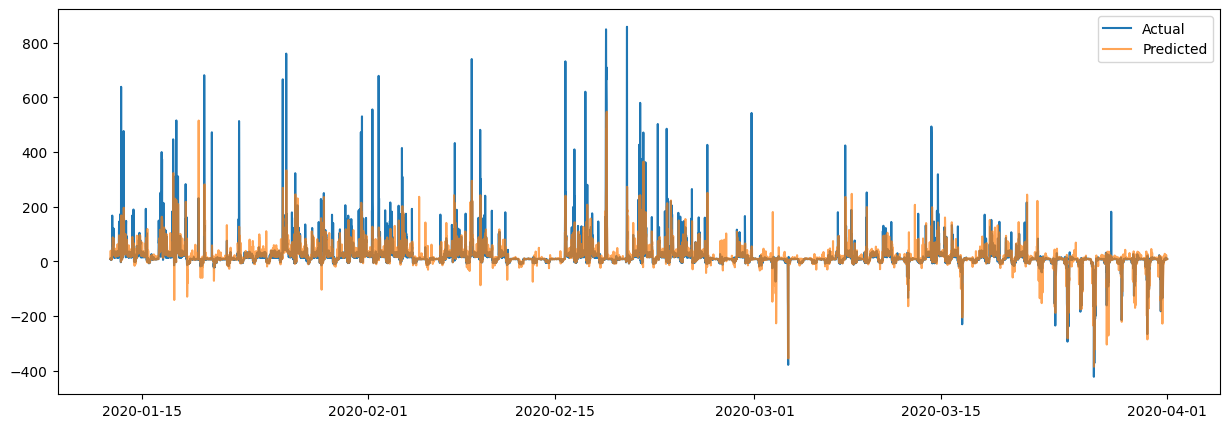

In [73]:
plt.figure(figsize=(15, 5))
plt.plot(test_target.index, test_target, label='Actual')
plt.plot(test_target.index, y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.show()